In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# set graph size for all following graphs
plt.rc('figure', figsize=(14, 7))

# Trend of Numerical Value - Outliers from Trend
The local bakery is offering free donuts this Saturday... 10x more people show up than average... this is an OUTLIER!!

Trends and rolling/moving averages are *time-series* concepts. They **require** a time element, whether that be a datetime index or an inherent/consistent progression index (ex: first, second, third, ...). 

**When you have timed data, you first want to ensure that the time index has a consistent interval.** You can **downsample** or **upsample** to get to a consistent time interval, **or leave the data alone if it is already consistent.** It depends on what you're looking to do.

If you can't get to a consistent time interval, then you should move on to different outlier detection approaches. The reason for this is simple: outlier detection is done using rolling/moving averages, and having an inconsistent time interval is going to artificially shift the averages at certain points. This artifical shift may make an outlier seem normal, or make a normal observation seem like an outlier. If you have an inconsistent time index, downsampling or upsampling are your best bet at establishing a consistent time index.

**Downsampling**- or in other words, reducing time precision and aggregating- is the most popular approach. You aggregate all values within the specified time interval, and this can be done without much thought. An example of this is taking all website visits in a day, counting them up (aggregation), and setting the day's values to the total visit count for the day. You can then compare how daily website visits rose or fall throughout a given year.

**Upsampling** means filling gaps in time (imputing) at a specific precision. For example, if you wanted a minute-by-minute precision on current temperature when your time precision is every few minutes (minute 1 is observed, minute 2 was missed, minute 3 was missed, minute 4 was observed), you can impute values for the gaps. EX: [30][??][??][33] would become [30][31][32][33]. **Caution must be taken for upsampling because *you* are choosing the imputation...** if you imputed the average overall temperature (using the average as the impute value is *sometimes* the best answer), you would get a weird result- like [30][64][64][33] for minute-by-minute temperatures. 

**NOTE: Generally, you should only use upsampling when you're confident that:**
- your imputation method doesn't ruin the data AND 
- when upsampling is absolutely necessary.

**Categorical aggregation is allowed in time-series outlier detection** (ex: total number of female customers in a day), but not allowed in other outlier detection methods like distance-based outlier detection. The reason is fairly simple: time-series outlier detection is focused on outliers in a trend (which *is* aggregation), while distance-based outlier detection is focused on individual data points (*no* aggregation). If you have a time element, you can make use of categorical data by aggregation... but **if you aren't using time-series outlier detection (ex: using distance-based instead), then you can't make use of your categorical data for outlier detection.** You would have to enumerate that categorical data somehow- which can only be done in very specific cases, like counting the number of times a word appears in a given sentence (which has few use cases).

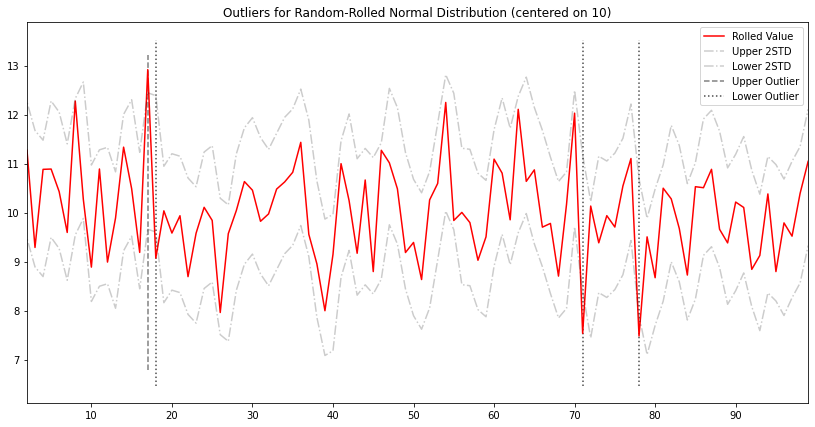

In [2]:
# generate normal distribution centered on 10 with 100 rolls, assign each rolled value to Series
norm_vals = pd.Series(np.random.normal(10, size=100))

# set number of values to calculate rolling average with
rolling_average_n = 2

# calculate Bollinger bands (rolling average for mid, and 2 standard deviations away for high/low)
mid_band = norm_vals.rolling(rolling_average_n).mean()
upper_band = mid_band + (2 * mid_band.std())
lower_band = mid_band - (2 * mid_band.std())

# find outliers with volatility (%b) (%b > 1 means value more than 2 standard deviations above mid)
volatility = (norm_vals - lower_band) / (upper_band - lower_band)
upper_outliers = norm_vals[volatility > 1]
lower_outliers = norm_vals[volatility < 0]

# set displayed values for graph
plt.xlim(rolling_average_n, 99)

# plot actual values, upper band, and lower band (horizontal-running lines)
sns.lineplot(x=norm_vals.index, y=norm_vals, color="red")
sns.lineplot(x=norm_vals.index, y=upper_band, color="black", ls="-.", alpha=.2)
sns.lineplot(x=norm_vals.index, y=lower_band, color="black", ls="-.", alpha=.2)

# plot upper outliers and lower outliers (vertical-running dotted/dashed lines)
plt.vlines(upper_outliers.index, *plt.ylim(), color='black', ls='--', alpha=.5, label='Upper Outlier')
plt.vlines(lower_outliers.index, *plt.ylim(), color='black', ls=':', alpha=.7, label='Lower Outlier')

# add title and legend, change tickmarks
plt.title("Outliers for Random-Rolled Normal Distribution (centered on 10)")
plt.legend(["Rolled Value", "Upper 2STD", "Lower 2STD", "Upper Outlier", "Lower Outlier"])
plt.xticks([i*10 for i in range(1,10)])

plt.show()

# Spread of Numerical Data - Outlier from Density
An open field in a grassy plain... a crowd gathers... people group up and chat... and the people left standing alone become OUTLIERS!!

Their proximity to one another allows us to determine outliers. Mentally, this is easily-conceptualized in two dimensions (like with the open field and the crowd, on the x,y coordinate plane, who is close together and who is far away)... but mentally, this is much more difficult to conceptualize in three dimensions- and practically impossible to conceptualize in 4+ dimensions.

You can think of x as a number and y as a number in this case (ex: meters). **Density-based outlier detection is strictly limited to numerical distances of individual data points**... as an example, the physical distances between people in the crowd doesn't relate to the people's names... or whether they're wearing bright clothes or not... so our density-based outlier detection doesn't incorporate that kind of data (**doesn't incorporate categorical/discrete data**). There are other outlier detection methods for that kind of data; density-based outlier detection only uses numerical data.

When you understand this, you first instinct may be to limit your data strictly to numerical data and let it fly... but this would be wrong. **You need to scale the numerical data before moving on.** Well, you may need to split the data before scaling- especially if you're going to do machine learning, but not really if you're just analyzing a given dataset. The reason you need to *scale* is hard to explain, but in simple terms... just as you would consider an inch insignificant in the course of a mile, an algorithm would consider a small change insignificant in the course of a large change. When one numerical column has small change (0.00-0.99) and another has large change (0-99), the small change gets drowned out. Scaling allows you to even the distances... scaling makes 0.00-0.99 weigh the same as 0-99, and this allows the algorithm to consider each fully.

So you've limited your columns to numerical data and (maybe split the data) and scaled the values... now you can move ahead with an algorithm like **DBSCAN** to do outlier detection. DBSCAN approaches the crowd-in-a-field problem much the same as we would... two people together aren't really a cluster, but 30 people together might be! That's our min_samples parameter. And maybe there's 30 people, but they're all more than 10 meters away from one another... that's not really a cluster, but 30 people all within a 10 meter area is probably a cluster! That's our epsilon (eps) parameter.

**Manual tuning of DBSCAN's "min_samples" and "eps" parameters helps us hone in on who to consider as outliers.** Once you've determined the outliers... you've achieved your objective! And can move on to whatever you plan to do with those outliers... *shudders*

### Build for and use DBSCAN

In [3]:
# create two normal-distribution arrays with 100 rolls each, assign to one another
norm_vals_1 = pd.Series(np.random.normal(10, size=100))
norm_vals_2 = pd.Series(np.random.normal(100, size=100))
df = pd.concat([norm_vals_1, norm_vals_2], axis=1)

# split data
train, test = train_test_split(df, test_size=.3)

# scale data
scaler = StandardScaler().fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# cluster using DBSCAN
eps_value = 0.5
clusters = DBSCAN(eps=eps_value, min_samples=3).fit_predict(scaled_train)
clustered_train = pd.DataFrame(scaled_train)
clustered_train["cluster"] = clusters

### Plot without/with DBSCAN

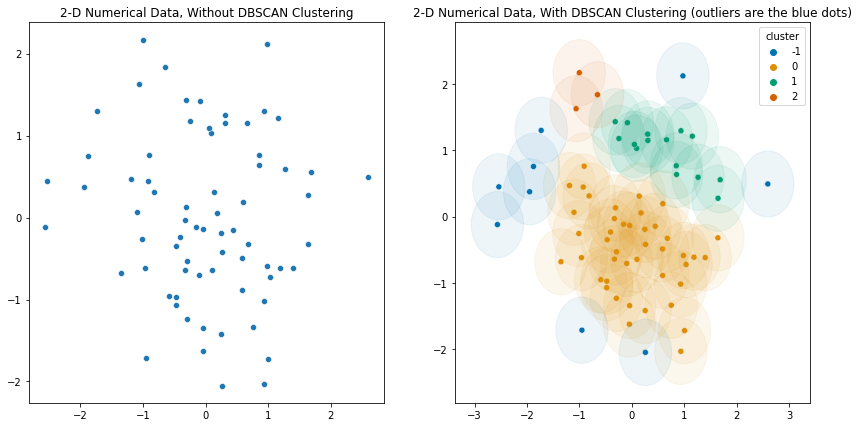

In [4]:
# plot graph without DBSCAN
plt.subplot(121)
# plot the two numerical columns as if one column is x and other is y (coordinates)
sns.scatterplot(data=clustered_train, 
                x=clustered_train[0], 
                y=clustered_train[1])
plt.title("2-D Numerical Data, Without DBSCAN Clustering")
plt.xlabel("")
plt.ylabel("")


# plot graph *with* DBSCAN
plt.subplot(122)
# plot the two numerical columns as if one column is x and other is y (coordinates)
sns.scatterplot(data=clustered_train, 
                x=clustered_train[0], 
                y=clustered_train[1], 
                hue=clustered_train["cluster"], # differentiate each dot's color by its cluster association
                palette="colorblind")
# iterate through each unique cluster
for cluster_number in clustered_train.cluster.unique():
    # set the color of the perimeter to the same color as the dot, kinda wonky
    point_color = sns.color_palette("colorblind")[cluster_number + 1]
    # iterate each row belonging to the current unique cluster
    for x, y, cluster in clustered_train[clustered_train.cluster == cluster_number].values:
        # plot the perimeter belonging to that point
        circle = plt.Circle((x, y), eps_value, color=point_color, alpha=.07)
        plt.gca().add_patch(circle)
plt.title("2-D Numerical Data, With DBSCAN Clustering (outliers are the blue dots)")
plt.xlabel("")
plt.ylabel("")


plt.show()